In [1]:
import os

# import healpy as hp
import numpy as np
import skyproj
# import proplot as pplt
import matplotlib.pyplot as plt
import fitsio

import rubin_sim
from rubin_sim import maf
from rubin_sim.scheduler.utils import SkyAreaGenerator
# from rubin_sim.utils import raDec2Hpid

from rubin_sim import maf

In [2]:
def mad(x, axis=None, no_scale=False):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis: int
        axis over which to take mode (default: None)
    no_scale: bool
        return MAD not scaled to match a Gaussian (default: False)

    Returns
    -------
    mad: float
        MAD of array x
    """
    kd = True if axis is not None else False
    mad = np.median(np.abs(x - np.median(x, axis=axis, keepdims=kd)), axis=axis)
    if no_scale:
        return mad
    else:
        return 1.4826 * mad

In [3]:
nside = 128

sm = SkyAreaGenerator(nside=nside)
footprints_hp_array, labels = sm.return_maps()
wfd_indx = np.where((labels == 'lowdust') | (labels == 'virgo'))[0]

In [4]:
def compute_map_stats(maps_arr, noroll_maps_arr):

    # msk = maps_arr < 0
    # maps_arr[msk] = 0

    # msk = noroll_maps_arr < 0
    # noroll_maps_arr[msk] = 0
    
    mdata = np.zeros(
        len(maps_arr),
        dtype=[
            (col, "f8", (2,))
            for col in [
                "med",
                "sd",
                "pt",
                "area",
            ]
        ] + [
            (col, "f8")
            for col in ["tlost", "alost"]
        ],
    )
    
    for i in range(len(maps_arr)):
        
        fmaps = maps_arr[i].copy()
        fmaps[~wfd_indx] = -9999
        fmaps = fmaps[fmaps > 15]
        if fmaps.shape == (0,):
            continue
        
        fnoroll_maps = noroll_maps_arr[i].copy()
        fnoroll_maps[~wfd_indx] = -9999        
        fnoroll_maps = fnoroll_maps[fnoroll_maps > 15]

        if fnoroll_maps.shape == (0,):
            continue
            
        mdata["med"][i, 0] = np.median(fmaps)
        mdata["med"][i, 1] = np.median(fnoroll_maps)

        mdata["sd"][i, 0] = mad(fmaps)
        mdata["sd"][i, 1] = mad(fnoroll_maps)
        
        ptval = 25
        mdata["pt"][i, 0] = np.percentile(fmaps, [ptval])
        mdata["pt"][i, 1] = np.percentile(fnoroll_maps, [ptval])
        
        mdata["tlost"][i] = (mdata["pt"][i, 1] - mdata["pt"][i, 0])/mdata["pt"][i, 1]

        ns = 3
        mn = np.median(fnoroll_maps)
        _sd = mad(fnoroll_maps)
        cut = mn-ns*_sd
        cut = mdata["pt"][i, 1]
        mdata["area"][i, 0] = np.sum(fmaps > cut)
        mdata["area"][i, 1] = np.sum(fnoroll_maps > cut)
        mdata["alost"][i] = (
            (mdata["area"][i, 1] - mdata["area"][i, 0])/mdata["area"][i, 1]
        )

    return mdata

In [ ]:
noroll_maps_arr = fitsio.read("noroll_v3.4_10yrs_nside128_bins40.fits")
baseline_maps_arr = fitsio.read("baseline_v3.4_10yrs_nside128_bins40.fits")
roll_uniform_maps_arr = fitsio.read("roll_uniform_early_half_mjdp0_v3.4_10yrs_nside128_bins40.fits")

import proplot as pplt
import glob

alpha = 1

rlabel = "baseline_v3.4"
nrlabel = "noroll_v3.4"
plabel = "roll_uniform_v3.4"

fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharey=0, sharex=0)

mdata = compute_map_stats(
    baseline_maps_arr,
    noroll_maps_arr,
)
pmdata = compute_map_stats(
    roll_uniform_maps_arr,
    noroll_maps_arr,
)

xy = np.linspace(0, 3653, 41)[1:]/365

axs[0].plot(
    xy, 
    mdata["pt"][:, 0]/(mdata["pt"][-1, 0]/10), 
    'k', 
    label=rlabel,
    alpha=alpha,
)
axs[0].plot(
    xy, 
    mdata["pt"][:, 1]/(mdata["pt"][-1, 1]/10), 
    'k--', 
    label=nrlabel,
)
axs[0].plot(
    xy, 
    pmdata["pt"][:, 0]/(pmdata["pt"][-1, 0]/10), 
    'k:', 
    label=plabel,
)
axs[0].set_ylabel("riz exposure time at 25th percentile relative to LSST Y1")
axs[0].legend(loc="t", frameon=False)

#     axs[1, 0].plot(xy, mdata["pt"][:, 1] - mdata["pt"][:, 0], 'k', alpha=alpha)
#     axs[1, 0].set_ylabel("rolling riz exposure time deficit at 25th percentile [sec]")

axs[1].plot(
    xy, 
    mdata["sd"][:, 0], 
    'k', 
    label=rlabel, 
)
axs[1].plot(
    xy, 
    mdata["sd"][:, 1], 
    'k--', 
    label=nrlabel,
)
axs[1].plot(
    xy, 
    pmdata["sd"][:, 0], 
    'k:', 
    label=plabel, 
)
# axs[1].plot(
#     xy, 
#     pmdata["sd"][:, 1], 
#     'r:', 
#     label=plabel, 
# )
axs[1].set_ylabel("riz exposure time scatter")
axs[1].legend(loc="t", frameon=False)

for ax in axs:
    ax.set_xlim(0, 10)
    ax.set_xlabel("year")
    ax.format(xticks=np.arange(0, 11))

fig.savefig(rlabel + ".png", dpi=300)

1.0008219178082192 222.39 222.39 222.39
2.0016438356164383 489.258 444.78 1601.2079999999999
3.0024657534246577 1690.164 1512.252 667.17
4.003287671232877 711.6479999999999 400.30199999999996 400.30199999999996
5.004109589041096 1601.2079999999999 1334.34 1378.818
6.004931506849315 711.6479999999999 711.6479999999999 756.126
7.005753424657534 1645.686 489.258 489.258
8.006575342465753 756.126 1334.34 1289.8619999999999
9.007397260273974 1556.73 800.6039999999999 800.6039999999999
10.008219178082191 622.692 578.2139999999999 578.2139999999999


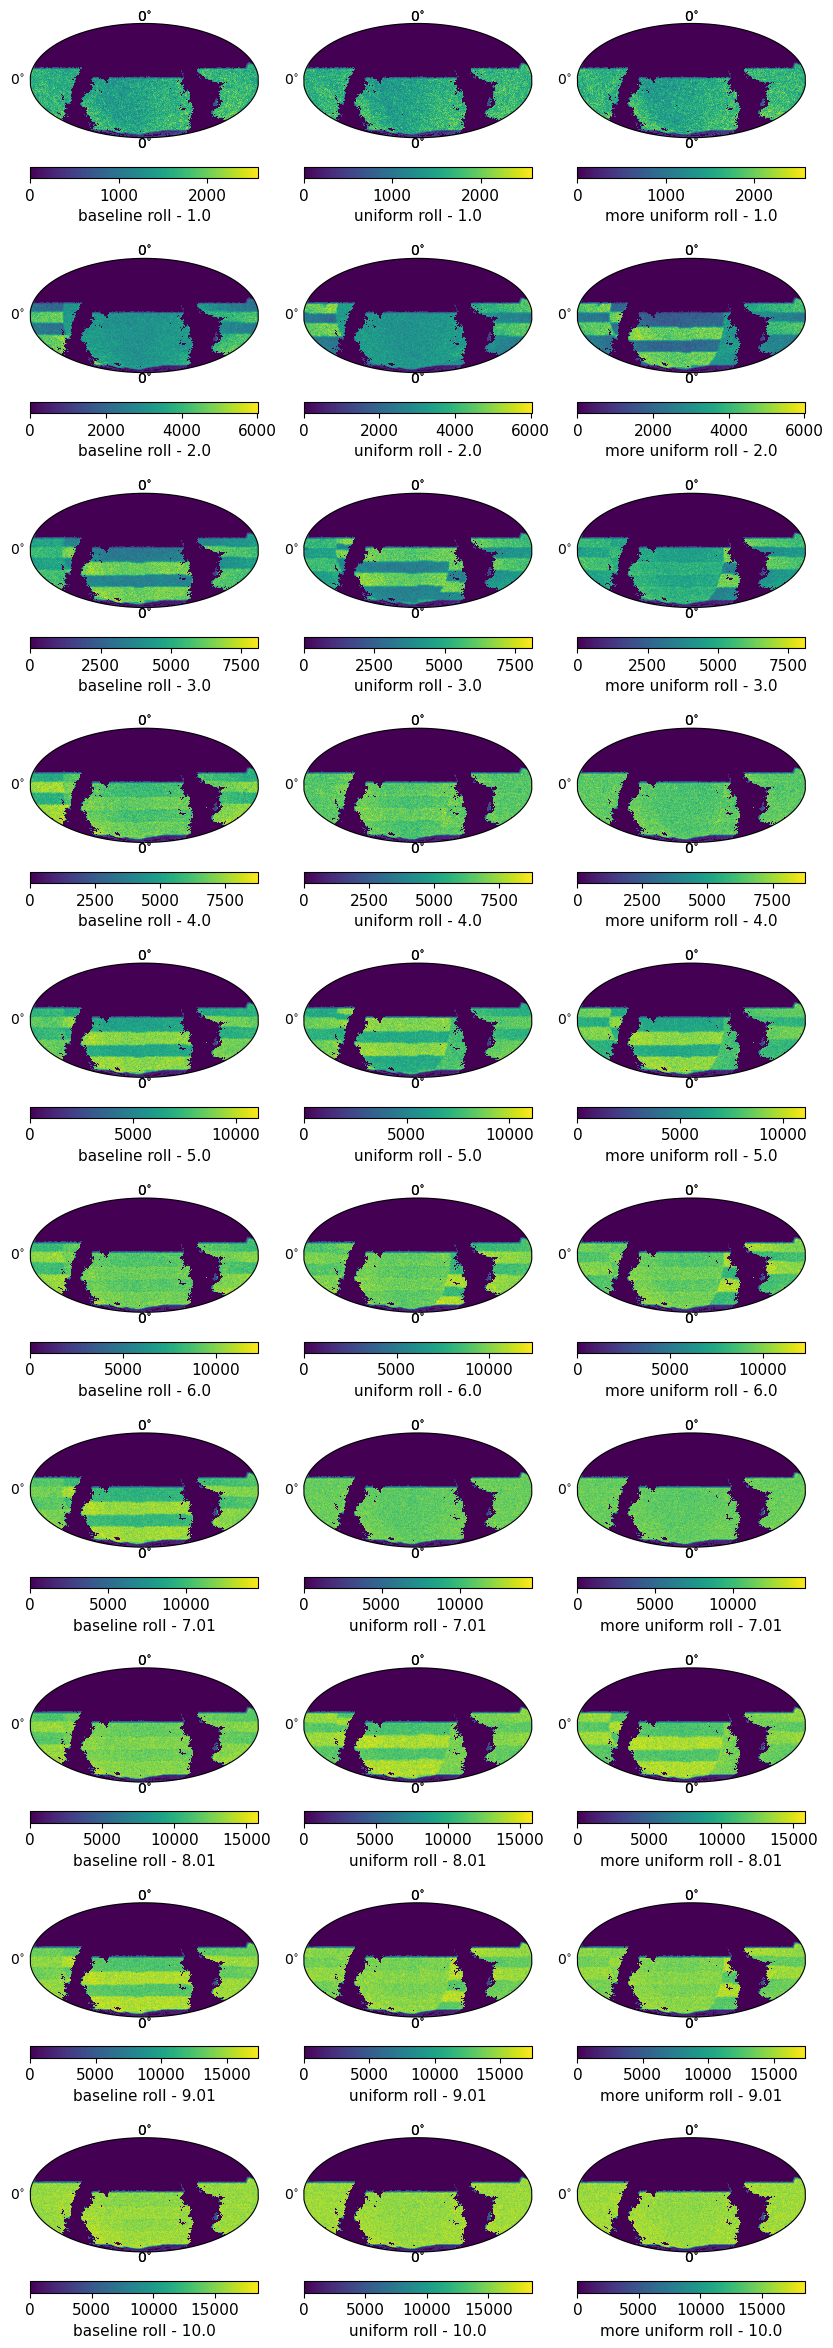

In [8]:
noroll_maps_arr = fitsio.read("noroll_v3.4_10yrs_nside128_bins40.fits")
baseline_maps_arr = fitsio.read("baseline_v3.3_10yrs_nside128_bins40.fits")
roll_uniform_maps_arr = fitsio.read("roll_uniform_mjdp0_v3.4_10yrs_nside128_bins40.fits")
better_roll_uniform_maps_arr = fitsio.read("roll_uniform_early_half_mjdp0_v3.4_10yrs_nside128_bins40.fits")

if True:
    msk = roll_uniform_maps_arr < 0
    roll_uniform_maps_arr[msk] = 0

    msk = better_roll_uniform_maps_arr < 0
    better_roll_uniform_maps_arr[msk] = 0
    
    msk = baseline_maps_arr < 0
    baseline_maps_arr[msk] = 0

# fig, axs = pplt.subplots(nrows=4, ncols=1)

xy = np.linspace(0, 3653, 41)[1:]/365

inds_to_plot = (np.arange(10) * 4 + 3).astype(int).tolist()
nplt = len(inds_to_plot)
fig, axs = plt.subplots(nrows=nplt, ncols=3, figsize=(10, 30))

for i in range(nplt):
    ind = inds_to_plot[i]
    print(
        xy[ind],
        mad(baseline_maps_arr[ind][wfd_indx]), 
        mad(roll_uniform_maps_arr[ind][wfd_indx]),
        mad(better_roll_uniform_maps_arr[ind][wfd_indx]),
    )
    all_maps = np.array([
        baseline_maps_arr[ind], 
        roll_uniform_maps_arr[ind],
        better_roll_uniform_maps_arr[ind]
    ])
    vmin = np.min(all_maps)
    vmax = np.max(all_maps)
    
    ax = axs[i, 0]
    # ax.set_title(f"baseline - {xy[ind+i]}")
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
    sp.draw_hpxmap(baseline_maps_arr[ind], vmin=vmin, vmax=vmax)
    sp.draw_colorbar(label=f"baseline roll - {xy[ind]:0.3}", location="bottom", pad=0.15)
    sp.set_xlabel(None)
    sp.set_ylabel(None)
    
    ax = axs[i, 1]
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
    sp.draw_hpxmap(roll_uniform_maps_arr[ind], vmin=vmin, vmax=vmax)
    sp.draw_colorbar(label=f"uniform roll - {xy[ind]:0.3}", location="bottom", pad=0.15)
    sp.set_xlabel(None)
    sp.set_ylabel(None)

    ax = axs[i, 2]
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
    sp.draw_hpxmap(better_roll_uniform_maps_arr[ind], vmin=vmin, vmax=vmax)
    sp.draw_colorbar(label=f"more uniform roll - {xy[ind]:0.3}", location="bottom", pad=0.15)
    sp.set_xlabel(None)
    sp.set_ylabel(None)
    
    # hp.mollview(maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i)
    # hp.mollview(bs_maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i, hold=True)

# fig.savefig(f"maps{phase}.png", dpi=300)

In [ ]:
import healpy as hp

def _extract_maps_dict(maps_to_use):
    year_inds = inds_to_plot = (np.arange(10) * 4 + 3).astype(int).tolist()

    
    orig_maps = {}
    all_maps = {}
    used_inds = {}
    ra_dec = {}
    for i, ind in enumerate(year_inds):
        orig_maps[i+1] = maps_to_use[ind]
        _map = maps_to_use[ind][wfd_indx]
        msk = _map > 15
        all_maps[i+1] = _map[msk]
        used_inds[i+1] = wfd_indx[msk]

    return all_maps, used_inds, orig_maps

noroll_maps_arr = fitsio.read("noroll_v3.4_10yrs_nside128_bins40.fits")
baseline_maps_arr = fitsio.read("baseline_v3.4_10yrs_nside128_bins40.fits")
roll_uniform_maps_arr = fitsio.read("roll_uniform_mjdp0_v3.4_10yrs_nside128_bins40.fits")

year_inds = inds_to_plot = (np.arange(10) * 4 + 3).astype(int).tolist()

bs_maps_dict, bs_inds, bs_orig_dict = _extract_maps_dict(baseline_maps_arr)
nr_maps_dict, nr_inds, _ = _extract_maps_dict(noroll_maps_arr)
ru_maps_dict, ru_inds, _ = _extract_maps_dict(roll_uniform_maps_arr)


def _plot_year(yind):

    bins = 500
    
    fig, axs = plt.subplots()
    # axs.hist(y3map, label="Y3", bins=bins, density=True);
    axs.hist(
        bs_maps_dict[yind] - np.median(bs_maps_dict[yind]), 
        label="Y%d - baseline %0.2f" % (
            yind, mad(bs_maps_dict[yind])
        ), 
        bins=bins, 
        density=True,
    );
    axs.hist(
        nr_maps_dict[yind] - np.median(nr_maps_dict[yind]), 
        label="Y%d - noroll %0.2f" % (
            yind, mad(nr_maps_dict[yind])
        ),
        bins=bins, 
        density=True,
    );
    axs.hist(
        ru_maps_dict[yind] - np.median(ru_maps_dict[yind]), 
        label="Y%d - opt. roll %0.2f" % (
            yind, 
            mad(ru_maps_dict[yind])
        ),
        bins=bins, 
        density=True
    );
    # axs.hist(y6map, label="Y6", bins=bins, density=True);
    axs.legend()
    return fig, axs

yind = 4
_plot_year(yind)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
n_clusters = 2
est = KMeans(n_clusters=n_clusters, n_init="auto")

In [ ]:
npix = baseline_maps_arr[0].shape[0]
x, y, z = hp.pix2vec(hp.npix2nside(npix), range(npix))
feats = np.vstack((bs_maps_dict[yind], x[bs_inds[yind]], y[bs_inds[yind]], z[bs_inds[yind]])).T

from sklearn.preprocessing import MinMaxScaler

nrmer = MinMaxScaler()
_feats = nrmer.fit_transform(feats)

print(_feats.shape)

_feats[:, 1:] *= 0.01

labels = est.fit_predict(_feats)

In [ ]:
for label in range(n_clusters):
    msk = labels == label
    print("label:", label)
    print("frac:", np.mean(msk))
    print("med:", np.median(bs_maps_dict[yind][msk]))

In [ ]:

fig, axs = plt.subplots(nrows=n_clusters // 2, ncols=2, figsize=(10, 16))


for label in range(n_clusters):
    pmap = baseline_maps_arr[0].copy()
    pmap[:] = np.nan
    pmap[bs_inds[yind][labels == label]] = 1.0

    sp = skyproj.MollweideSkyproj(
        ax=axs.flatten()[label], gridlines=False, n_grid_lon=1, n_grid_lat=1,
    )
    sp.draw_hpxmap(pmap, zoom=False);
    sp.set_xlabel(None)
    sp.set_ylabel(None)

fig, ax = plt.subplots()
sp = skyproj.MollweideSkyproj(
    ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1,
)
sp.draw_hpxmap(bs_orig_dict[yind], zoom=False);


In [ ]:
bs22 = fitsio.read("baseline_v2.2_10yrs_nside128_bins40.fits")
bs34 = fitsio.read("baseline_v3.4_10yrs_nside128_bins40.fits")
bs33 = fitsio.read("baseline_v3.3_10yrs_nside128_bins40.fits")

maps = [bs22, bs33, bs34]
map_labels = ["v2.2", "v3.3", "v3.4"]

for map_arr in maps:
    msk = map_arr < 0
    map_arr[msk] = 0
    

xy = np.linspace(0, 3653, 41)[1:]/365

inds_to_plot = [39]
nplt = 1
fig, axs = plt.subplots(nrows=nplt, ncols=3, figsize=(10, nplt*4))

for i in range(nplt):
    ind = inds_to_plot[i]
    for maps_arr in maps:
        print(
            xy[ind],
            mad(maps_arr[ind][wfd_indx]), 
        )
    all_maps = np.array([
        maps_arr[ind]
        for maps_arr in maps
    ])
    vmin = np.min(all_maps)
    vmax = np.max(all_maps)

    for j, maps_arr in enumerate(maps):
        ax = axs[j]
        # ax.set_title(f"baseline - {xy[ind+i]}")
        sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
        sp.draw_hpxmap(maps_arr[ind], vmin=vmin, vmax=vmax)
        sp.draw_colorbar(label=f"baseline {map_labels[j]} - {xy[ind]:0.3}", location="bottom", pad=0.15)
    
    
    # hp.mollview(maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i)
    # hp.mollview(bs_maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i, hold=True)

# fig.savefig(f"maps{phase}.png", dpi=300)

### Check Phased Rolling

In [ ]:
import proplot as pplt
import glob

alpha = 1

rlabel = "111UDUDUDUD (baseline_v3.4)"
nrlabel = "noroll_v3.4"
bl_mdata = compute_map_stats(baseline_maps_arr.copy(), noroll_maps_arr)


fig, axs = pplt.subplots(ncols=1, nrows=1, figsize=(6, 6), sharey=0, sharex=0)


fnames = [
    "roll_pause_mjdp0_v3.4_10yrs_nside128_bins40.fits",
    "roll_pause_mjdp60_v3.4_10yrs_nside128_bins40.fits",
    "roll_pause_mjdp120_v3.4_10yrs_nside128_bins40.fits",
    "roll_pause_mjdp180_v3.4_10yrs_nside128_bins40.fits",
    "roll_pause_mjdp270_v3.4_10yrs_nside128_bins40.fits",
    # "roll_pause_mjdp365_v3.4_10yrs_nside128_bins40.fits",
]
names = [
    fname.replace("_v3.4_10yrs_nside128_bins40.fits", "")
    for fname in fnames
]
cmap = pplt.Colormap("crest")
colors = [cmap(i/ (len(fnames) - 1)) for i in range(len(fnames))]
for i, fname in enumerate(fnames):
    maps_arr = fitsio.read(fname)
    _nrmaps_arr = fitsio.read(fname.replace("roll_pause", "noroll"))
    mdata = compute_map_stats(maps_arr, _nrmaps_arr)
    name = names[i]
    

    off = 0
    xy = np.linspace(0, 3653, 41)[1:]/365
    
#     axs[1, 0].plot(xy, mdata["pt"][:, 1] - mdata["pt"][:, 0], 'k', alpha=alpha)
#     axs[1, 0].set_ylabel("rolling riz exposure time deficit at 25th percentile [sec]")

    axs[0].plot(
        xy + off, 
        mdata["sd"][:, 0], 
        label=name, alpha=alpha, color=colors[i], lw=2
    )
    axs[0].plot(
        xy + off, 
        mdata["sd"][:, 1], 
        linestyle="dashed", alpha=alpha, color=colors[i], lw=2
    )
    # if i == len(fnames)-1:
        # axs[1].plot(xy, bl_mdata["sd"][:, 0], 'k:', label=rlabel)
    # axs[0].plot(xy, mdata["sd"][:, 1], 'k--', label=name + nrlabel)
    axs[0].set_ylabel("ratio of riz exposure time scatter (roll / noroll)")
    if i == len(fnames)-1:
        axs[0].legend(loc="t", frameon=False, ncol=3)

    for ax in axs:
        ax.set_xlim(0, 10)
        # axs.set_ylim(0.75, 2)
        ax.set_xlabel("year")
        ax.format(xticks=np.arange(0, 11))
        
fig.savefig("roll_pause_start_time.png", dpi=300)

In [ ]:
import proplot as pplt
import glob

alpha = 1


fnames = [
    "roll_pause_mjdp0_v3.4_10yrs_nside128_bins40.fits",
    "roll_pause_mjdp60_v3.4_10yrs_nside128_bins40.fits",
    "roll_pause_mjdp120_v3.4_10yrs_nside128_bins40.fits",
    "roll_pause_mjdp180_v3.4_10yrs_nside128_bins40.fits",
    "roll_pause_mjdp270_v3.4_10yrs_nside128_bins40.fits",
    "roll_pause_mjdp365_v3.4_10yrs_nside128_bins40.fits",
]
nr_fnames = [
    fname.replace("roll_pause", "noroll")
    for fname in fnames
]
names = [
    fname.replace("_v3.4_10yrs_nside128_bins40.fits", "")
    for fname in fnames
]

fnames += ["baseline_v3.4_10yrs_nside128_bins40.fits"]
nr_fnames += ["noroll_v3.4_10yrs_nside128_bins40.fits"]
names += ["baseline"]

data = []

for i, fname in enumerate(fnames):
    maps_arr = fitsio.read(fname)
    _nrmaps_arr = fitsio.read(nr_fnames[i])
    mdata = compute_map_stats(maps_arr, _nrmaps_arr)
    data.append([
        mdata["sd"][:, 0],
        mdata["sd"][:, 1],
    ])

stime = np.linspace(0, 3653, 41)[1:]/365
sphase = np.array([0, 60, 120, 180, 270, 360])
data = np.array(data)

print(data.shape)

data = data[:, :, 3::4]
stime = stime[3::4]

ndata = len(data[0, 0, :])

cmap = pplt.Colormap("crest")
ncolors = ndata
colors = [cmap(v) for v in np.linspace(0, 1, ncolors)]


fig, axs = pplt.subplots(
    ncols=1, nrows=ndata,
    share=4, wspace=0, hspace=1,
    figsize=(3, 5)
)

for i in range(ndata):
    print(stime[i])
    ax = axs[i, 0]
    ax.plot(
        sphase, 
        data[:-1, 0, i] / data[:-1, 1, i], 
        label=f"{stime[i]:0.3}", 
        color=colors[i - sind]
    )
    ax.legend(loc="ur")

for i in range(ndata):
    ax = axs[i, 0]

    ax.axhline(
        data[-1, 0, i] / data[-1, 1, i],  
        color=colors[i - sind], 
        linestyle="dashed",
    )

# axs.legend(loc="t", ncols=4, frameon=False)

## Plot the Maps

In [ ]:
phase = "0"
bs_maps_arr = fitsio.read(f"noroll_mjdp{phase}_v3.4_10yrs_nside128_bins40.fits")
# maps_arr = fitsio.read(f"roll_pause_mjdp{phase}_v3.4_10yrs_nside128_bins40.fits")
maps_arr = fitsio.read(f"baseline_v3.4_10yrs_nside128_bins40.fits")

if True:
    msk = maps_arr < 0
    maps_arr[msk] = 0
    # maps_arr = np.cumsum(maps_arr, axis=0)
    
    msk = bs_maps_arr < 0
    bs_maps_arr[msk] = 0
    # bs_maps_arr = np.cumsum(bs_maps_arr, axis=0)

# fig, axs = pplt.subplots(nrows=4, ncols=1)

xy = np.linspace(0, 3653, 41)[1:]/365

ind = 38
# ind = 6
nplt = 2
fig, axs = plt.subplots(nrows=nplt, ncols=2, figsize=(10, nplt*4))

for i in range(nplt):
    print(
        xy[ind+i],
        mad(bs_maps_arr[ind+i][wfd_indx]), 
        mad(maps_arr[ind+i][wfd_indx]),
    )
    all_maps = np.array([bs_maps_arr[ind+i], maps_arr[ind+i]])
    vmin = np.min(all_maps)
    vmax = np.max(all_maps)
    
    ax = axs[i, 0]
    # ax.set_title(f"baseline - {xy[ind+i]}")
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
    sp.draw_hpxmap(bs_maps_arr[ind+i], vmin=vmin, vmax=vmax)
    sp.draw_colorbar(label=f"noroll - {xy[ind+i]:0.3}", location="bottom", pad=0.15)
    
    ax = axs[i, 1]
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
    sp.draw_hpxmap(maps_arr[ind+i], vmin=vmin, vmax=vmax)
    sp.draw_colorbar(label=f"roll_pause_mjdp{phase} - {xy[ind+i]:0.3}", location="bottom", pad=0.15)
    
    # hp.mollview(maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i)
    # hp.mollview(bs_maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i, hold=True)

# fig.savefig(f"maps{phase}.png", dpi=300)

In [ ]:
phase = "0"
phase2 = "0"
bs_maps_arr = fitsio.read(f"baseline_v3.4_10yrs_nside128_bins40.fits")
maps_arr = fitsio.read(f"roll_pause_mjdp{phase2}_v3.4_10yrs_nside128_bins40.fits")

if True:
    msk = maps_arr < 0
    maps_arr[msk] = 0
    # maps_arr = np.cumsum(maps_arr, axis=0)
    
    msk = bs_maps_arr < 0
    bs_maps_arr[msk] = 0
    # bs_maps_arr = np.cumsum(bs_maps_arr, axis=0)

# fig, axs = pplt.subplots(nrows=4, ncols=1)

xy = np.linspace(0, 3653, 41)[1:]/365

ind = 11
# ind = 0
nplt = 6
fig, axs = plt.subplots(nrows=nplt, ncols=2, figsize=(10, nplt*6))

for i in range(nplt):
    print(
        xy[ind+i],
        mad(bs_maps_arr[ind+i][wfd_indx]), 
        mad(maps_arr[ind+i][wfd_indx]),
    )
    all_maps = np.array([bs_maps_arr[ind+i], maps_arr[ind+i]])
    vmin = np.min(all_maps)
    vmax = np.max(all_maps)
    
    ax = axs[i, 0]
    # ax.set_title(f"baseline - {xy[ind+i]}")
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=8, n_grid_lat=1)
    sp.draw_hpxmap(bs_maps_arr[ind+i], vmin=vmin, vmax=vmax)
    sp.draw_colorbar(label=f"roll_pause_mjdp{phase} - {xy[ind+i]:0.3}", location="bottom", pad=0.15)
    
    ax = axs[i, 1]
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=8, n_grid_lat=1)
    sp.draw_hpxmap(maps_arr[ind+i], vmin=vmin, vmax=vmax)
    sp.draw_colorbar(label=f"roll_pause_mjdp{phase2} - {xy[ind+i]:0.3}", location="bottom", pad=0.15)
    
    # hp.mollview(maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i)
    # hp.mollview(bs_maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i, hold=True)

# fig.savefig(f"maps{phase}.png", dpi=300)

In [ ]:
phase1 = "180"
tb_maps_arr = fitsio.read(f"baseline_v3.4_10yrs_nside128_bins40.fits")
nr_maps_arr = fitsio.read(f"noroll_mjdp{phase1}_v3.4_10yrs_nside128_bins40.fits")
maps_arr = fitsio.read(f"roll_pause_mjdp{phase1}_v3.4_10yrs_nside128_bins40.fits")

if True:
    msk = maps_arr < 0
    maps_arr[msk] = 0
    # maps_arr = np.cumsum(maps_arr, axis=0)
    
    msk = bs_maps_arr < 0
    bs_maps_arr[msk] = 0
    # bs_maps_arr = np.cumsum(bs_maps_arr, axis=0)

# fig, axs = pplt.subplots(nrows=4, ncols=1)

xy = np.linspace(0, 3653, 41)[1:]/365

ind = 14
nplt = 3
fig, axs = plt.subplots(nrows=nplt, ncols=3, figsize=(10, nplt*3))

for i in range(nplt):
    print(
        mad(tb_maps_arr[ind+i][wfd_indx]), 
        mad(nr_maps_arr[ind+i][wfd_indx]), 
        mad(maps_arr[ind+i][wfd_indx]),
    )
    all_maps = np.array([bs_maps_arr[ind+i], maps_arr[ind+i]])
    vmin = np.min(all_maps)
    vmax = np.max(all_maps)

    ax = axs[i, 0]
    # ax.set_title(f"baseline - {xy[ind+i]}")
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
    sp.draw_hpxmap(tb_maps_arr[ind+i], vmin=vmin, vmax=vmax)
    sp.draw_colorbar(label=f"baseline v3.4- {xy[ind+i]:0.3}", location="bottom", pad=0.15)    
    sp.set_xlabel("")
    sp.set_ylabel("")
    
    ax = axs[i, 1]
    # ax.set_title(f"baseline - {xy[ind+i]}")
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
    sp.draw_hpxmap(bs_maps_arr[ind+i], vmin=vmin, vmax=vmax)
    sp.draw_colorbar(label=f"noroll v3.4 - {xy[ind+i]:0.3}", location="bottom", pad=0.15)
    sp.set_xlabel("")
    sp.set_ylabel("")
    
    ax = axs[i, 2]
    sp = skyproj.MollweideSkyproj(ax=ax, gridlines=False, n_grid_lon=1, n_grid_lat=1)
    sp.draw_hpxmap(maps_arr[ind+i], vmin=vmin, vmax=vmax)
    sp.draw_colorbar(label=f"roll_pause_mjdp{phase1} v3.4 - {xy[ind+i]:0.3}", location="bottom", pad=0.15)
    sp.set_xlabel("")
    sp.set_ylabel("")
    
    # hp.mollview(maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i)
    # hp.mollview(bs_maps_arr[ind+i], nest=False, title=f"{xy[ind+i]}", fig=i, hold=True)

# fig.savefig(f"maps{phase}.png", dpi=300)

In [ ]:
import numpy as np


class BasePixelEvolution:
    """Helper class that can be used to describe the time evolution of a
    HEALpix in a footprint.
    """

    def __init__(self, period=365.25, rise=1.0, t_start=0.0):
        self.period = period
        self.rise = rise
        self.t_start = t_start

    def __call__(self, mjd_in, phase):
        pass


class StepLine(BasePixelEvolution):
    """
    Parameters
    ----------
    period : `float`
        The period to use
    rise : `float`
        How much the curve should rise every period
    """

    def __call__(self, mjd_in, phase):
        t = mjd_in + phase - self.t_start
        n_periods = np.floor(t / (self.period))
        result = n_periods * self.rise
        tphased = t % self.period
        step_area = np.where(tphased > self.period / 2.0)[0]
        result[step_area] += (tphased[step_area] - self.period / 2) * self.rise / (0.5 * self.period)
        result[np.where(t < 0)] = 0
        return result


class StepSlopes(BasePixelEvolution):
    """
    Parameters
    ----------
    period : `float`
        The period to use - typically should be a year.
    rise : np.array-like
        How much the curve should rise each period.
    """

    def __call__(self, mjd_in, phase):
        steps = np.array(self.rise)
        t = mjd_in + phase - self.t_start
        season = np.floor(t / (self.period))
        season = season.astype(int)
        plateus = np.cumsum(steps) - steps[0]
        result = plateus[season]
        tphased = t % self.period
        step_area = np.where(tphased > self.period / 2.0)[0]
        result[step_area] += (
            (tphased[step_area] - self.period / 2) * steps[season + 1][step_area] / (0.5 * self.period)
        )
        result[np.where(t < 0)] = 0

        return result


In [ ]:
import proplot as pplt

year = 365.25

fig, axs = pplt.subplots()

c = StepSlopes(rise=np.array([1.0, 1.9, 1.0/1.9, 1.0, 1.0, 1.0, 1.0]), t_start=year * -0.25)
mjd_in = np.arange(0, int(c.period*5))
res = c(mjd_in, 0)

m0 = axs.plot(mjd_in/c.period, res, label="phase: -0.25 years")

c = StepSlopes(rise=np.array([1.0, 1.9, 1.0/1.9, 1.0, 1.0, 1.0, 1.0]), t_start=year * 0.0)
mjd_in = np.arange(0, int(c.period*5))
res = c(mjd_in, 0)

m1 = axs.plot(mjd_in/c.period, res, label="phase: 0.00 years")

axs.format(xlabel="years", ylabel="thing I do not understand")

axs.legend([m0, m1], loc="t")


In [ ]:
import proplot as pplt

year = 365.25

fig, axs = pplt.subplots()

c = StepSlopes(rise=np.array([1.0, 1.9, 1.0/1.9, 1.0, 1.0, 1.0, 1.0]), t_start=year * 0.0)
mjd_in = np.arange(0, int(c.period*5))
res = c(mjd_in, 0)

m0 = axs.plot(mjd_in/c.period, res, label="1UD111")

c = StepSlopes(rise=np.array([1.0, 1.0/1.9, 1.9, 1.0, 1.0, 1.0, 1.0]), t_start=year * 0.0)
mjd_in = np.arange(0, int(c.period*5))
res = c(mjd_in, 0)

m1 = axs.plot(mjd_in/c.period, res, label="1DU111")

axs.format(xlabel="years", ylabel="thing I do not understand")

axs.legend([m0, m1], loc="t")


In [ ]:
import proplot as pplt

year = 365.25

U = 1.9
D = 1.0 / U

fig, axs = pplt.subplots()

c = StepSlopes(rise=np.array([1, U, D, U, D, 1, 1]), t_start=year * 0.0)
mjd_in = np.arange(0, int(c.period*5))
res = c(mjd_in, 0)

m0 = axs.plot(mjd_in/c.period, res, label="1UD1111")

c = StepSlopes(rise=np.array([1.0, D, U, D, U, 1, 1]), t_start=year * 0.0)
mjd_in = np.arange(0, int(c.period*5))
res = c(mjd_in, 0)

m1 = axs.plot(mjd_in/c.period, res, label="1DU111")

axs.format(xlabel="season", ylabel="target # of obs")

axs.legend([m0, m1], loc="t")


In [ ]:
def _do_the_thing(ra):
    sun_ra_rad = 0.0
    offset = ra - sun_ra_rad + 2.0 * np.pi
    offset = offset % (np.pi * 2)
    offset = offset * 365.25 / (np.pi * 2)
    offset = -offset - 365.25    
    return offset

In [ ]:
x = np.linspace(0, 4.0 * np.pi, 100)
y = _do_the_thing(x)

fig, axs = pplt.subplots()
axs.plot(x / 2.0 / np.pi, y / 365.25)

In [ ]:


trans = {
    1.0: "1",
    0.0: "0",
    1.8: "U",
    (1.0 - 0.8): "D",
}

def make_rolling_footprints_mid1(
    fp_hp=None,
    mjd_start=60218.0,
    sun_ra_start=3.27717639,
    nslice=2,
    scale=0.8,
    nside=32,
    wfd_indx=None,
    order_roll=0,
    n_cycles=3,
    n_constant_start=3,
    n_constant_end=6,
    *,
    insert_const=None
):
    """
    Generate rolling footprints

    Parameters
    ----------
    fp_hp : dict-like
        A dict with filtername keys and HEALpix map values
    mjd_start : float
        The starting date of the survey.
    sun_ra_start : float
        The RA of the sun at the start of the survey
    nslice : int (2)
        How much to slice the sky up. Can be 2, 3, 4, or 6.
    scale : float (0.8)
        The strength of the rolling, value of 1 is full power rolling, zero is no rolling.
    wfd_indx : array of ints (none)
        The indices of the HEALpix map that are to be included in the rolling.
    order_roll : int (0)
        Change the order of when bands roll. Default 0.
    n_cycles : int (None)
        Number of complete rolling cycles to attempt. If None, defaults to 3
        full cycles for nslice=2, 2 cycles for nslice=3 or 4, and 1 cycle for
        nslice=6.
    n_constant_start : int (3)
        The number of constant non-rolling seasons to start with. Anything less
        than 3 results in rolling starting before the entire sky has had a constant year.
    n_constant_end : int (6)
        The number of constant seasons to end the survey with. Defaults to 6.

    Returns
    -------
    Footprints object
    """

    nc_default = {2: 3, 3: 2, 4: 2, 6: 1}
    if n_cycles is None:
        n_cycles = nc_default[nslice]

    hp_footprints = fp_hp

    down = 1.0 - scale
    up = nslice - down * (nslice - 1)

    start = [1.0] * n_constant_start
    # After n_cycles, just go to no-rolling for 6 years.
    end = [1.0] * n_constant_end

    rolling = [up] + [down] * (nslice - 1)
    rolling = rolling * n_cycles

    rolling = np.roll(rolling, order_roll).tolist()

    if insert_const is not None:
        rolling.insert(insert_const, 1)

    all_slopes = [start + np.roll(rolling, i).tolist() + end for i in range(nslice)]
    for foot in range(1):
        slopes = all_slopes[foot]
        print("mid1 - %s: %s" % (
            insert_const or "N",
            " ".join(trans[s] for s in slopes)
        ))


def make_rolling_footprints_mid2(
    fp_hp=None,
    mjd_start=60218.0,
    sun_ra_start=3.27717639,
    nslice=2,
    scale=0.8,
    nside=32,
    wfd_indx=None,
    order_roll=0,
    n_cycles=2,
    n_constant_start=3,
    n_constant_end=6,
    *,
    insert_const
):
    """
    Generate rolling footprints

    Parameters
    ----------
    fp_hp : dict-like
        A dict with filtername keys and HEALpix map values
    mjd_start : float
        The starting date of the survey.
    sun_ra_start : float
        The RA of the sun at the start of the survey
    nslice : int (2)
        How much to slice the sky up. Can be 2, 3, 4, or 6.
    scale : float (0.8)
        The strength of the rolling, value of 1 is full power rolling, zero is no rolling.
    wfd_indx : array of ints (none)
        The indices of the HEALpix map that are to be included in the rolling.
    order_roll : int (0)
        Change the order of when bands roll. Default 0.
    n_cycles : int (None)
        Number of complete rolling cycles to attempt. If None, defaults to 3
        full cycles for nslice=2, 2 cycles for nslice=3 or 4, and 1 cycle for
        nslice=6.
    n_constant_start : int (3)
        The number of constant non-rolling seasons to start with. Anything less
        than 3 results in rolling starting before the entire sky has had a constant year.
    n_constant_end : int (6)
        The number of constant seasons to end the survey with. Defaults to 6.

    Returns
    -------
    Footprints object
    """

    nc_default = {2: 3, 3: 2, 4: 2, 6: 1}
    if n_cycles is None:
        n_cycles = nc_default[nslice]

    hp_footprints = fp_hp

    down = 1.0 - scale
    up = nslice - down * (nslice - 1)

    start = [1.0] * n_constant_start
    # After n_cycles, just go to no-rolling for 6 years.
    end = [1.0] * n_constant_end

    rolling = [up] + [down] * (nslice - 1)
    rolling = rolling * n_cycles

    rolling = np.roll(rolling, order_roll).tolist()

    if insert_const is not None:
        rolling.insert(insert_const, 1)

    all_slopes = [start + np.roll(rolling, i).tolist() + end for i in range(nslice)]
    for foot in range(1):
        slopes = all_slopes[foot]
        print("mid2 - %s: %s" % (
            insert_const or "N",
            " ".join(trans[s] for s in slopes)
        ))


make_rolling_footprints_mid1(insert_const=None)
for i in [2, 4, 6]:
    make_rolling_footprints_mid1(insert_const=i)

make_rolling_footprints_mid2(insert_const=None)
for i in [2, 4, 6]:
    make_rolling_footprints_mid2(insert_const=i)